In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import h5py
import torch 
import torch.nn.functional as F
from torch.nn.functional import interpolate

from torch.utils.data import DataLoader

import evidence_loss
import dataloader_utils

from sklearn.metrics import ConfusionMatrixDisplay
from torchmetrics import ConfusionMatrix

import numpy as np

## Model Definition

Using 2 images : image0 and image1 and uses sequence dataloader

ToDo : Still need to verify if it works with on single image "image1" for validation. 
I was done in notebook "EvaluationUncertainFusion.ipynb"

In [3]:

class SequenceRoboCupModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, 
                 K, Kinv, combine_method, fusion_method, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.combine_method = combine_method
        self.n_classes = out_classes
        
        self.epoch = 0
        self.ignore_class = 0.0 #ignore background class  fr loss function
        
        self.K = K 
        self.Kinv = Kinv
        
        self.confmat = ConfusionMatrix(num_classes=out_classes, normalize='pred')
        
        self.fusion = fusion_method


    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask
    
    def dempster_schafer_combine(self, alpha1, alpha2):
        # Calculate the merger of two DS evidences
        alpha = dict()
        alpha[0], alpha[1] = alpha1, alpha2
        b, S, E, u = dict(), dict(), dict(), dict()
        for v in range(2):
            S[v] = torch.sum(alpha[v], dim=1, keepdim=True)
            E[v] = alpha[v] - 1
            b[v] = E[v] / (S[v].expand(E[v].shape))
            u[v] = self.n_classes / S[v]

        # b^0 @ b^(0+1)
        bb = torch.bmm(b[0].view(-1, self.n_classes, 1), b[1].view(-1, 1, self.n_classes))
        # b^0 * u^1
        uv1_expand = u[1].expand(b[0].shape)
        bu = torch.mul(b[0], uv1_expand)
        # b^1 * u^0
        uv_expand = u[0].expand(b[0].shape)
        ub = torch.mul(b[1], uv_expand)
        # calculate K
        bb_sum = torch.sum(bb, dim=(1, 2), out=None)
        bb_diag = torch.diagonal(bb, dim1=-2, dim2=-1).sum(-1)
        # bb_diag1 = torch.diag(torch.mm(b[v], torch.transpose(b[v+1], 0, 1)))
        K = bb_sum - bb_diag

        # calculate b^a
        b_a = (torch.mul(b[0], b[1]) + bu + ub) / ((1 - K).view(-1, 1).expand(b[0].shape))
        # calculate u^a
        u_a = torch.mul(u[0], u[1]) / ((1 - K).view(-1, 1).expand(u[0].shape))
        # test = torch.sum(b_a, dim = 1, keepdim = True) + u_a #Verify programming errors

        # calculate new S
        S_a = self.n_classes / u_a
        # calculate new e_k
        e_a = torch.mul(b_a, S_a.expand(b_a.shape))
        alpha_a = e_a + 1
        return alpha_a
    
    def epipolar_propagate(self, batch, logits):
        bs, num_channels, height, width = batch['image0'].size()
        
        #Getting depth and flatenning it and making it [n, 1, height*width] shape
        flattened_depth = torch.flatten(batch['depth0'], start_dim=1)
        flattened_depth = torch.unsqueeze(flattened_depth, dim=1).float()

        #Getting Transformation and Rotation from previous frame
        T = batch['translation_old_to_new_camera_frame'].float().to(self.device)
        R = batch['rotation_old_to_new_camera_frame'].float().to(self.device)

        #Getting index of each pixel of image in [n,3, height*width] shape device=self.device
        grid_x, grid_y = torch.meshgrid(torch.arange(height, device=self.device), 
                                        torch.arange(width, device=self.device), indexing='ij')
        grid_x = torch.flatten(grid_x, start_dim=0)
        grid_y = torch.flatten(grid_y, start_dim=0)
        ## Stacking to make the matrix 3 x points
        index = torch.vstack((grid_x, grid_y, torch.ones_like(grid_y))).float()

        #Camera intrinsics
        K = torch.tensor(self.K).float().to(self.device)
        Kinv = torch.tensor(self.Kinv).float().to(self.device)

        #Epipolar Geometry
        transposed_index = torch.matmul(torch.matmul(torch.matmul(K, R), Kinv), index) + torch.matmul(K,torch.div(T, flattened_depth))
        ## Dividing Last column for each image
        transposed_index = torch.div(transposed_index, transposed_index[:,2,:].unsqueeze(1))
        ## Clamping index
        transposed_index = torch.clamp(transposed_index, min=0, max=511).long() # imagesize is 512 ,  1 
        #Projecting pixels from previous frame based on the transposed index
        projected_tensor = torch.zeros_like(logits, device=self.device)

        #ToDo can this be done without for loop
        for i,p in enumerate(transposed_index):
            projected_tensor[i,:,p[0],p[1]] = logits[i,:,grid_x, grid_y]

        projected_tensor = projected_tensor.float()
        #m = torch.nn.MaxPool2d(2)
        projected_tensor = F.max_pool2d(projected_tensor, kernel_size=2)

        projected_tensor = interpolate(projected_tensor, scale_factor=2 )
        
        return projected_tensor

    def shared_step(self, batch, stage):
        image0 = batch["image0"]
        image1 = batch["image1"]
        depth0 = batch["depth0"]
        

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image0.ndim == 4
        
        bs, num_channels, height, width = image0.size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image0.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask0 = batch["mask0"]
        mask1 = batch["mask1"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask0.ndim == 4
        assert mask1.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask0.max() <= 255.0 and mask0.min() >= 0
        assert mask1.max() <= 255.0 and mask1.min() >= 0

        logits_mask0 = self.forward(image0)
        propagate_mask0 = self.epipolar_propagate(batch, logits_mask0)
        
        logits_mask1 = self.forward(image1)
      
       
        
        #unroll the tensor to single tensor 
        # [batch_size, 1, height, width] -> [batch_size*height*width]
        mask1 = torch.ravel(mask1)      
        #Remove pixels exculding the background loss function
        idx_only_objects = mask1 != self.ignore_class      
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True       
        mask1 = F.one_hot(mask1.long(), self.n_classes)  # [batch_size*height*width] -> [batch_size*height*width, n_classes]
        
        # [batch_size, n_classes, height, width] -> [batch_size,n_classes, height*width]
        logits_mask1 = logits_mask1.view(bs, self.n_classes, -1)
        propagate_mask0 = propagate_mask0.view(bs, self.n_classes, -1)
        # [batch_size,n_classes, height*width] -> [batch_size, height*width, n_classes]
        logits_mask1 = logits_mask1.permute(0,2,1)
        propagate_mask0 = propagate_mask0.permute(0,2,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        logits_mask1 = logits_mask1.reshape_as(mask1)        
        propagate_mask0 = propagate_mask0.reshape_as(mask1)        
        
        #Fluctute between all loss and only objects loss excluding bakground
        if (stage == "train"):
            if self.epoch % 3 == 0:
                loss = evidence_loss.edl_mse_loss(logits_mask1, mask1, self.epoch, self.n_classes, 10)
            else:
                loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], mask1[idx_only_objects], self.epoch, self.n_classes, 10)
        else:
            loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], 
                                              mask1[idx_only_objects], 
                                              self.epoch, self.n_classes, 10)

     
        #combining evidence
        if "sum" == self.combine_method:
            logits_mask1 = logits_mask1 + propagate_mask0
            prob_mask = logits_mask1.log_softmax(dim=1).exp()
        elif "belief_sum" == self.combine_method:
            prob_mask = self.dempster_schafer_combine(torch.relu(logits_mask1) + 1,
                                                         torch.relu(propagate_mask0) + 1)
        elif "bayes" == self.combine_method:
            #Making non negative and adding 1 for dirichlet 
            logits_mask1  = torch.relu(logits_mask1) + 1
            propagate_mask0  = torch.relu(propagate_mask0) + 1
            # Finding mean of dirichlet distirbution which is a multinomial distribuion
            #formula is same as softmat
            logits_mask1 = torch.softmax(logits_mask1, dim=1)
            propagate_mask0 = torch.softmax(propagate_mask0, dim=1)
            prob_mask = self.fusion(propagate_mask0, logits_mask1)
            prob_mask = prob_mask.to(self.device)
        elif "single" == self.combine_method:
            prob_mask = logits_mask1.log_softmax(dim=1).exp()
        else:
            raise Exception("Please define combine method") 
            
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        pred_mask = prob_mask.argmax(dim=1, keepdim=True)
         
        #Changing back to original dimension for metrics calculation
        mask1 = mask1.argmax(dim=1, keepdim=True)
        
        #Confusion matrix calculation
        confusion_matrix = self.confmat(pred_mask, mask1)
        
        pred_mask = pred_mask.reshape(bs, 1, height, width )
        mask1 = mask1.reshape(bs, 1, height, width)
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(),
                                               mask1.long(), 
                                               mode="multiclass", 
                                               num_classes=self.n_classes)
       
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "confusion_matrix":confusion_matrix
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        # then compute metrics with required reduction (see metric docs)
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        # aggregate step metics
        loss = [x["loss"].item() for x in outputs]
        
        #confusion matrix sum
        self.cm = torch.sum(torch.stack([x["confusion_matrix"] for x in outputs]), dim=0)
        print (self.cm.shape)

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_evidential_loss": np.mean(loss)
        }
        
        self.log_dict(metrics, prog_bar=True)
        self.epoch += 1

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

-----

## Dataloader 

In [4]:
root = '../learning_blenerproc/images_pose_robocup/'

valid_dataset = dataloader_utils.SequenceRoboCupDataset(root, "two_sequence")
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=int(16/2))


[['0000.hdf5', '0001.hdf5'], ['0001.hdf5', '0002.hdf5'], ['0003.hdf5', '0004.hdf5'], ['0004.hdf5', '0005.hdf5'], ['0006.hdf5', '0007.hdf5'], ['0007.hdf5', '0008.hdf5'], ['0009.hdf5', '0010.hdf5'], ['0010.hdf5', '0011.hdf5'], ['0012.hdf5', '0013.hdf5'], ['0013.hdf5', '0014.hdf5'], ['0015.hdf5', '0016.hdf5'], ['0016.hdf5', '0017.hdf5'], ['0018.hdf5', '0019.hdf5'], ['0019.hdf5', '0020.hdf5'], ['0021.hdf5', '0022.hdf5'], ['0022.hdf5', '0023.hdf5'], ['0024.hdf5', '0025.hdf5'], ['0025.hdf5', '0026.hdf5'], ['0027.hdf5', '0028.hdf5'], ['0028.hdf5', '0029.hdf5'], ['0030.hdf5', '0031.hdf5'], ['0031.hdf5', '0032.hdf5'], ['0033.hdf5', '0034.hdf5'], ['0034.hdf5', '0035.hdf5'], ['0036.hdf5', '0037.hdf5'], ['0037.hdf5', '0038.hdf5'], ['0039.hdf5', '0040.hdf5'], ['0040.hdf5', '0041.hdf5'], ['0042.hdf5', '0043.hdf5'], ['0043.hdf5', '0044.hdf5'], ['0045.hdf5', '0046.hdf5'], ['0046.hdf5', '0047.hdf5'], ['0048.hdf5', '0049.hdf5'], ['0049.hdf5', '0050.hdf5'], ['0051.hdf5', '0052.hdf5'], ['0052.hdf5', '0053

In [6]:
max_count = {}
for sample in valid_dataset:
    mask_values, count = np.unique(sample["mask0"], return_counts=True)
    zip_count = dict(zip(mask_values, count))
    max_count = dict(list(max_count.items()) + list(zip_count.items()))
    
print(max_count)

{0.0: 243297, 1.0: 3259, 2.0: 3230, 3.0: 5565, 4.0: 2958, 5.0: 3835}


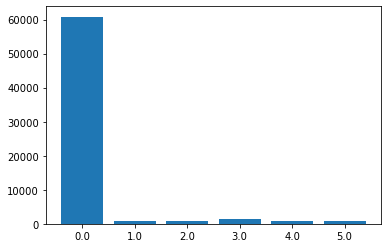

In [36]:
import matplotlib.pyplot as plt

names = list(max_count.keys())
values = list(max_count.values())

plt.bar(range(len(max_count)), values, tick_label=names)
plt.show()

---------

## Validation

In [16]:
model = SequenceRoboCupModel("FPN", "timm-mobilenetv3_small_minimal_100", in_channels=3, out_classes=8, combine_method='sum',
                            K=valid_dataset.K, Kinv=valid_dataset.Kinv)
model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
)
# run validation dataset
#valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
#pprint(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


-----------

In [109]:
def c(prior_prediction, current_prediction):
    print("vv",prior_prediction.shape,  prior_prediction) 
    print("cc", current_prediction.shape, current_prediction)
    
    return prior_prediction+current_prediction, prior_prediction-current_prediction

def d(prior_prediction, current_prediction):
    print("v",prior_prediction.shape,  prior_prediction) 
    print("c", current_prediction.shape, current_prediction)
    gcds = map(c, prior_prediction, current_prediction) # calling map with more than 1 iterables

    gcds = list(gcds)
    list1, list2 = zip(*gcds)
    return np.array(list1), np.array(list2)

prior = np.ones((1, 2, 3))
prediction = np.ones((1, 2, 3))*2


#np.apply_along_axis(d, 2, combined)

gcds = map(d, prior, prediction) # calling map with more than 1 iterables

gcds = list(gcds)
list1, list2 = zip(*gcds)
print (np.array(list1).shape)
print (np.array(list2))


v (2, 3) [[1. 1. 1.]
 [1. 1. 1.]]
c (2, 3) [[2. 2. 2.]
 [2. 2. 2.]]
vv (3,) [1. 1. 1.]
cc (3,) [2. 2. 2.]
vv (3,) [1. 1. 1.]
cc (3,) [2. 2. 2.]
(1, 2, 3)
[[[-1. -1. -1.]
  [-1. -1. -1.]]]


--------

## Fusion class

### Install efprob

In [118]:
!wget https://efprob.cs.ru.nl/efprob.zip
!unzip efprob.zip


--2022-07-13 10:47:02--  https://efprob.cs.ru.nl/efprob.zip
Resolving efprob.cs.ru.nl (efprob.cs.ru.nl)... 131.174.9.235
Connecting to efprob.cs.ru.nl (efprob.cs.ru.nl)|131.174.9.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61196 (60K) [application/zip]
Saving to: ‘efprob.zip.1’

efprob.zip.1        100%[===================>]  59.76K  --.-KB/s    in 0.05s   

2022-07-13 10:47:02 (1.15 MB/s) - ‘efprob.zip.1’ saved [61196/61196]

Archive:  efprob.zip
replace efprob_dc.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


-------------

### class definition

In [7]:
import efprob_dc as efprob_dc


In [139]:
class EffectiveProbability(torch.nn.Module):
    def __init__(self, confusion_matrix, fusion_type='bayes'):
        super(EffectiveProbability, self).__init__()
        
        assert confusion_matrix.ndim == 2
        
        self.confusion_matrix = confusion_matrix
        
        #Effective probability 
        self.n_classes = confusion_matrix.shape[0]
        prior_labels = []
        current_labels = []
        for i in range(self.n_classes):
            prior_labels.append('P'+str(i))
            current_labels.append('C'+str(i))
        self.prior_labels_dom = efprob_dc.Dom(prior_labels)
        self.current_labels_dom = efprob_dc.Dom(current_labels)
        
        self.array_of_states = []
        for s in self.confusion_matrix:
            self.array_of_states.append(efprob_dc.State(s, self.current_labels_dom))
        self.chan = efprob_dc.chan_from_states(self.array_of_states, self.prior_labels_dom)
  
            
        self.fusion_type = fusion_type
            
    def single_row_calculation(self, prior, current):
        assert prior.ndim == 1
        assert current.ndim == 1
        assert prior.shape[0] == self.n_classes
        assert current.shape[0] == self.n_classes
        
        prior_dc = efprob_dc.State(prior, self.prior_labels_dom)
        
        try:
            if "bayes" == self.fusion_type:
                posterior = prior_dc / (self.chan << efprob_dc.Predicate(current, self.current_labels_dom))
            elif "dampster" == self.fusion_type:
                posterior = self.chan.inversion(prior_dc) >> efprob_dc.State(current, self.current_labels_dom)
            else:
                print ("select fusion_type as bayes or dampster")
        except:
            print(prior, current)

        return posterior.array
    
        
    def forward(self, prior, current):
        assert prior.ndim == 4
        assert current.ndim == 4
        assert prior.shape == current.shape
        assert prior.shape[1] == self.n_classes
        assert current.shape[1] == self.n_classes
        
        # [batch_size,n_classes, height, width] -> [batch_size, height, width, n_classes]
        prior = prior.permute(0,2,3,1)
        current = current.permute(0,2,3,1)
        # [batch_size, height, width, n_classes] -> [batch_size*height*width, n_classes]
        prior = prior.reshape(-1, self.n_classes) 
        current = current.reshape(-1, self.n_classes) 
        
        #Converting dirchlet to probability
        prior = prior/prior.sum(dim=1, keepdim=True)
        current = current/current.sum(dim=1, keepdim=True)
        
        prior = prior.cpu().detach().numpy()
        current = current.cpu().detach().numpy()
     
        posterior = map(self.single_row_calculation, 
                    prior, 
                    current)
       
        return torch.tensor(np.array(list(posterior)))
                
    

In [9]:
cm = torch.rand(6,6)
cm = cm.cpu().detach().numpy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

array([[2.01531273e-01, 1.99882284e-01, 1.99127623e-01, 1.17811613e-01,
        1.28801122e-01, 1.52846018e-01],
       [2.31663879e-01, 2.16498292e-01, 2.01152606e-01, 9.47974378e-02,
        3.52911582e-02, 2.20596613e-01],
       [2.63598891e-01, 4.20364142e-01, 8.45732168e-02, 4.20129171e-02,
        1.26460508e-01, 6.29903239e-02],
       [2.99122915e-01, 1.75773065e-01, 3.70740413e-02, 8.56828109e-02,
        2.16285040e-01, 1.86062157e-01],
       [2.69948710e-01, 7.64564844e-02, 6.33482212e-02, 1.25849424e-01,
        3.20405471e-01, 1.43991690e-01],
       [3.84121798e-04, 3.02598971e-01, 2.32389743e-01, 1.41117251e-01,
        1.96793093e-01, 1.26716797e-01]])

In [94]:
ef_fusion = EffectiveProbability(confusion_matrix=cm)

In [96]:
prior = torch.rand(10,6,5,5)# [batch_size,n_classes, height, width]

current = torch.rand(10,6,5, 5)# [batch_size,n_classes, height, width]

print (prior.shape)
posterior = ef_fusion(prior, current)
print (posterior.shape)

torch.Size([10, 6, 5, 5])
torch.Size([250, 6])


In [31]:
a = torch.tensor([[1.,2,1,1],
                  [2., 3, 2, 2]])
torch.nn.functional.softmax(a, dim=1)

tensor([[0.1749, 0.4754, 0.1749, 0.1749],
        [0.1749, 0.4754, 0.1749, 0.1749]])

In [34]:
a/a.sum(dim=1, keepdim=True) + 1

tensor([[1.2000, 1.4000, 1.2000, 1.2000],
        [1.2222, 1.3333, 1.2222, 1.2222]])

In [15]:
%timeit
posterior = ef_fusion(prior, current)
print (posterior.shape)

torch.Size([2621440, 6])


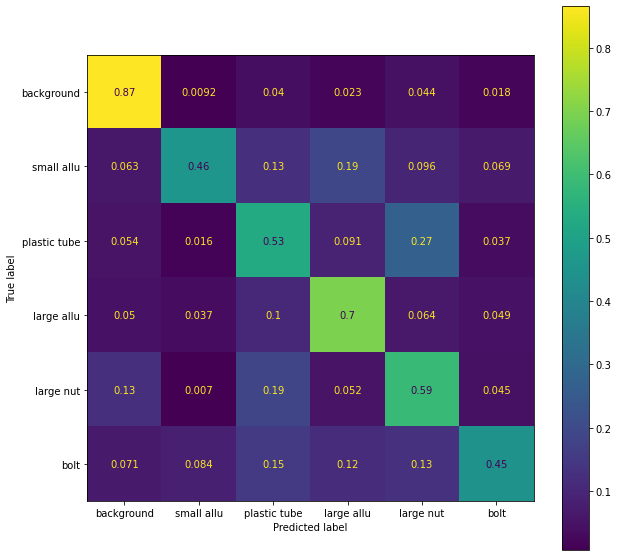

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=list(valid_dataset.class_names.values()))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

# Valiation 

## Validation with single 

In [6]:
with open('robocup_mobilenet_cm.npy', 'rb') as f:
    cm = np.load(f)
print (cm.shape)
ef_fusion = EffectiveProbability(confusion_matrix=cm)

(6, 6)


In [12]:

model = SequenceRoboCupModel("FPN", "timm-mobilenetv3_small_minimal_100", 
                             in_channels=3, 
                             out_classes=6, 
                             combine_method='single',
                             K=valid_dataset.K, 
                             Kinv=valid_dataset.Kinv, 
                             fusion_method=ef_fusion
                             )
model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
)
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

RuntimeError: shape '[10, 6, -1]' is invalid for input of size 18350080

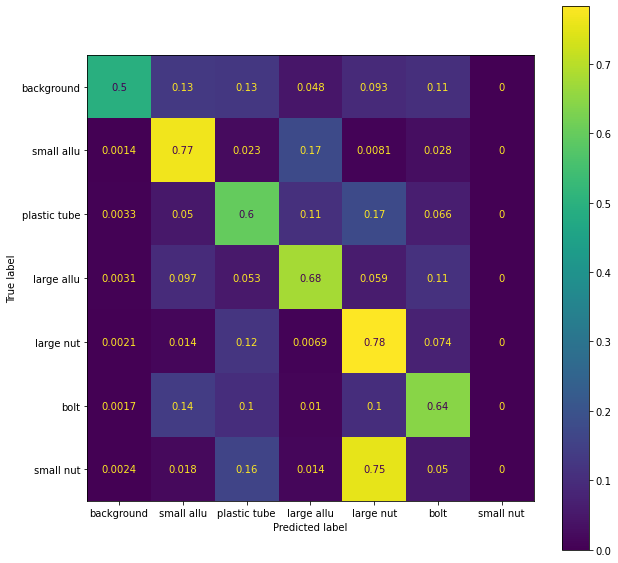

In [22]:
cm = model.cm.cpu().detach().numpy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.shape
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=list(valid_dataset.class_names.values()))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## Validation with Adition fusion

In [23]:

model = SequenceRoboCupModel("FPN", "timm-mobilenetv3_small_minimal_100", 
                             in_channels=3, 
                             out_classes=7, 
                             combine_method='sum',
                             K=valid_dataset.K, 
                             Kinv=valid_dataset.Kinv, 
                             fusion_method=ef_fusion
                             )
model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
)
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

torch.Size([7, 7])
[{'valid_per_image_iou': 0.9234182238578796, 'valid_dataset_iou': 0.9226863384246826, 'valid_evidential_loss': 0.6246548891067505}]


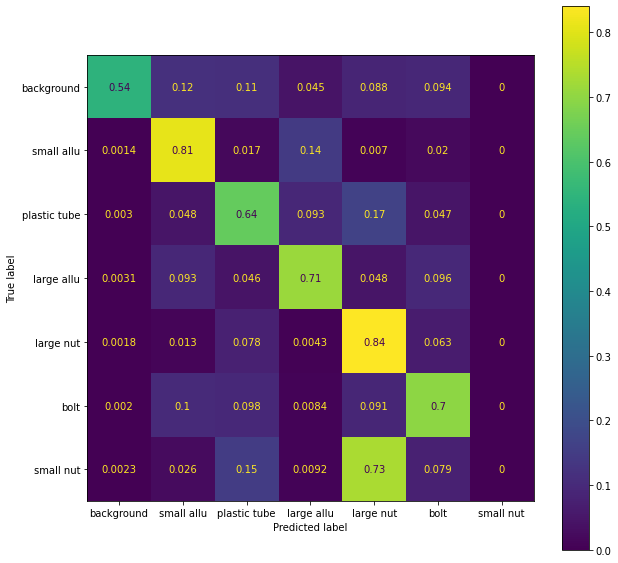

In [24]:
cm = model.cm.cpu().detach().numpy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(cm, display_labels=list(valid_dataset.class_names.values()))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## Validation with Effective Bayesian Fusion 

In [18]:
#Create fusion class
ef_fusion_dampster = EffectiveProbability(confusion_matrix=cm, fusion_type='bayes')

model = SequenceRoboCupModel("FPN", "timm-mobilenetv3_small_minimal_100", 
                             in_channels=3, 
                             out_classes=6, 
                             combine_method='bayes',
                             K=valid_dataset.K, 
                             Kinv=valid_dataset.Kinv, 
                             fusion_method=ef_fusion_dampster
                             )
model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=200,
)
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

torch.Size([7, 7])
[{'valid_per_image_iou': 0.9142459034919739, 'valid_dataset_iou': 0.9134470224380493, 'valid_evidential_loss': 0.6268107891082764}]


## Validation with Effective Dampster Fusion 

In [11]:
with open('robocup_mobilenet_cm.npy', 'rb') as f:
    cm = np.load(f)

In [25]:
#Create fusion class
ef_fusion_dampster = EffectiveProbability(confusion_matrix=cm, fusion_type='dampster')

model = SequenceRoboCupModel("FPN", "timm-mobilenetv3_small_minimal_100", 
                             in_channels=3, 
                             out_classes=7, 
                             combine_method='bayes',
                             K=valid_dataset.K, 
                             Kinv=valid_dataset.Kinv, 
                             fusion_method=ef_fusion_dampster
                             )
model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')

# CPU accelerator
trainer = pl.Trainer(accelerator="cpu")
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1579: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

/home/deebuls/Documents/phd/blender-dataset/semantic_segmentation/efprob_dc.py:952: RuntimeWarning: Encountered 0 during disintegration; produces a subprobability channel
  warnings.warn("Encountered 0 during disintegration; produces a subprobability channel",


None


/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Epipolar Geometry Class

In [115]:
class EpipolarPropagation(torch.nn.Module):
    '''
    EpipolarPropagation propagates a batch tensor based on the depth 
    and camera parameters.
    ASSUMPTION: Works on on square images because of the clamping
    TODO : Find a way of better clamping rather than magic number 511
    ToDo Remove the loop for filling
    TODO : Assert of intrinsic and image height . need to check datagenerator
    
    '''
    def __init__(self, K, Kinv, height, width, fill_empty_with_ones=0):
        super(EpipolarPropagation, self).__init__()
        
        assert K.ndim == 2
        assert Kinv.ndim == 2
        assert height == width #Onlt works for square images, update in dataloader
        
        self.fill_empty_with_ones = fill_empty_with_ones
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(self.device,  )
        
        self.K = torch.Tensor(K).float().to(self.device)
        self.Kinv = torch.Tensor(Kinv).float().to(self.device)
        self.height = height
        self.width = width
        
        #checking if cmaera intrinsic is alligned with the image size
        #assert K[0,2]*2 == height
        #commeinting htis as intrinsix image size is 511 and actual image is 512 need to debug
        
        #Getting index of each pixel of image in [n,3, height*width] shape device=self.device
        self.grid_x, self.grid_y = torch.meshgrid(torch.arange(height, device=self.device), 
                                        torch.arange(width, device=self.device), indexing='ij')
        self.grid_x = torch.flatten(self.grid_x, start_dim=0)
        self.grid_y = torch.flatten(self.grid_y, start_dim=0)
        ## Stacking to make the matrix 3 x points
        self.index = torch.vstack((self.grid_x, self.grid_y, torch.ones_like(self.grid_y))).float()
        
    def forward(self, image, depth, T, R):
        assert torch.is_tensor(image) == True
        assert torch.is_tensor(depth) == True
        assert torch.is_tensor(T) == True
        assert torch.is_tensor(R) == True
        assert image.ndim == 4
        assert depth.ndim == 3
                
        #Getting depth and flatenning it and making it [n, 1, height*width] shape
        flattened_depth = torch.flatten(depth, start_dim=1)
        flattened_depth = torch.unsqueeze(flattened_depth, dim=1).float().to(self.device)

        #Getting Transformation and Rotation from previous frame
        T = T.float().to(self.device)
        R = R.float().to(self.device)
        

        #Epipolar Geometry
        transposed_index = ( torch.matmul(torch.matmul(torch.matmul(self.K, R), self.Kinv), self.index) + 
                             torch.matmul(self.K,torch.div(T, flattened_depth)) )
        ## Dividing Last column for each image
        transposed_index = torch.div(transposed_index, transposed_index[:,2,:].unsqueeze(1))
        ## Clamping index ,  imagesize subtracting 1
        transposed_index = torch.clamp(transposed_index, min=0, max=self.height-1).long() # 
        #Projecting pixels from previous frame based on the transposed index
        if self.fill_empty_with_ones:
            projected_tensor = torch.ones_like(image, device=self.device)
        else:
            projected_tensor = torch.zeros_like(image, device=self.device)

        image = image.to(self.device)
        #ToDo can this be done without for loop
        for i,p in enumerate(transposed_index):
            projected_tensor[i,:,p[0],p[1]] = image[i,:,self.grid_x, self.grid_y]

        projected_tensor = projected_tensor.float()
        #m = torch.nn.MaxPool2d(2)
        projected_tensor = F.max_pool2d(projected_tensor, kernel_size=2)

        projected_tensor = interpolate(projected_tensor, scale_factor=2 )
        
        return projected_tensor

In [4]:
batch = next(iter(valid_dataloader))

In [5]:
print (torch.get_device(batch['image0']))

-1


In [6]:
bs, channel, height, width = batch['image0'].shape

In [7]:
batch['depth0'].shape

torch.Size([10, 512, 512])

In [8]:
epipolar_propagation = EpipolarPropagation(valid_dataset.K, valid_dataset.Kinv, height, width )

cuda


In [158]:
projected_image = epipolar_propagation(batch['mask0'], 
                                         batch['depth0'], 
                                         batch['translation_old_to_new_camera_frame'],
                                         batch['rotation_old_to_new_camera_frame'])

In [159]:
projected_image.shape

torch.Size([10, 1, 512, 512])

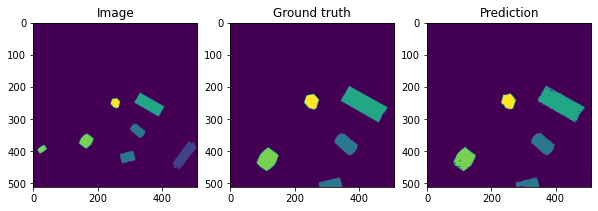

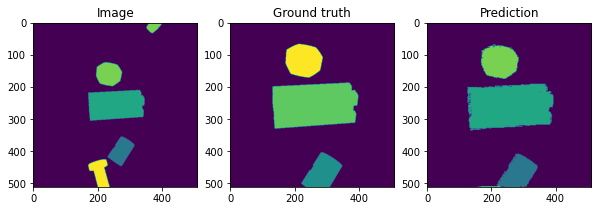

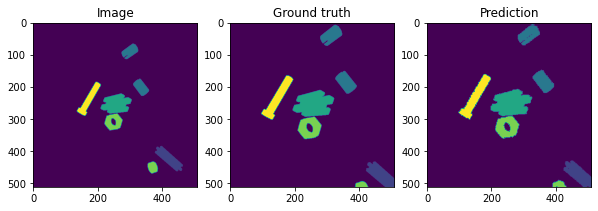

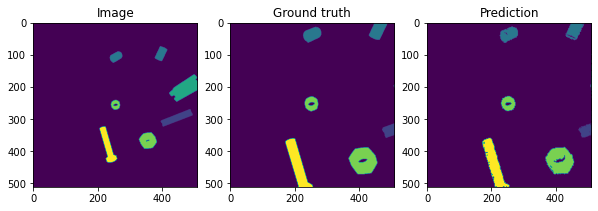

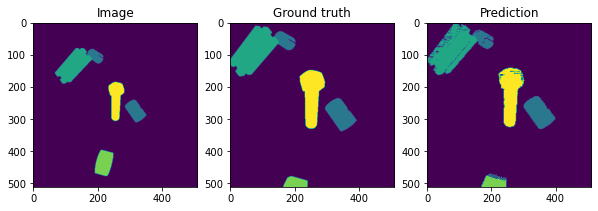

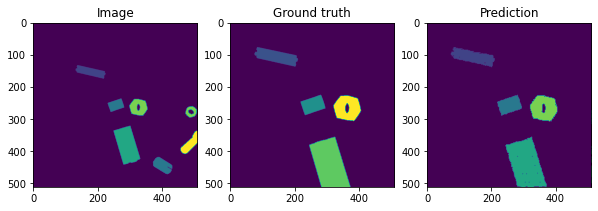

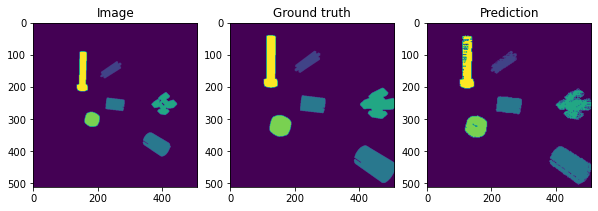

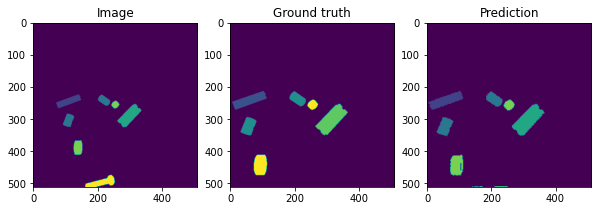

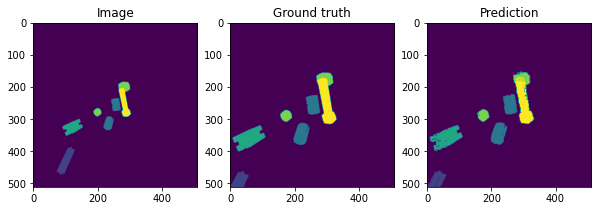

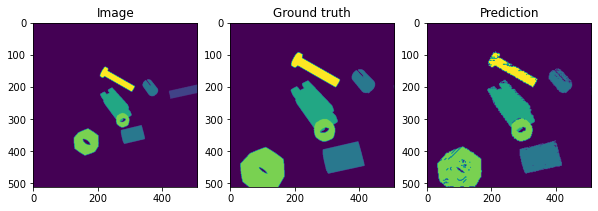

In [160]:
for prev_image, curr_image, pr_image in zip(batch["mask0"], batch["mask1"], projected_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(prev_image.numpy().squeeze())  # convert CHW -> HWC
    plt.title("Image")
    #plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(curr_image.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    #plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_image.cpu().detach().numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    #plt.axis("off")
    
  
    plt.show()
    

### Debugging  

Copying code from debugSemanticSegmentation notebook where

The problem was in iamge size and the camera intrinsic parameters . 

In [141]:
flattened_depth = torch.flatten(batch['depth0'], start_dim=1)
flattened_depth = torch.unsqueeze(flattened_depth, dim=1)
print ("flateneded Depth ", flattened_depth.shape)
T = batch['translation_old_to_new_camera_frame']
print ("Translatio : ", T.shape,)
print (T[0])
R = batch['rotation_old_to_new_camera_frame'].double()
print ("Rotation : ", R.shape,  R[0])

flateneded Depth  torch.Size([10, 1, 65536])
Translatio :  torch.Size([10, 3, 1])
tensor([[ 0.0011],
        [-0.0005],
        [-0.1451]], dtype=torch.float64)
Rotation :  torch.Size([10, 3, 3]) tensor([[ 1.0000e+00, -1.3878e-17, -5.5511e-17],
        [ 1.3878e-17,  1.0000e+00,  0.0000e+00],
        [ 5.5511e-17,  5.5511e-17,  1.0000e+00]], dtype=torch.float64)


In [142]:
print (valid_dataset.K)

[[711.11127387   0.         255.5       ]
 [  0.         711.11127387 255.5       ]
 [  0.           0.           1.        ]]


In [167]:
valid_dataset.K[0,2]*2

511.0

# Dampster Fusion creating class

## old code

In [182]:
def dempster_schafer_combine(alpha1, alpha2):
        bs, n_classes = alpha1.shape
        # Calculate the merger of two DS evidences
        alpha = dict()
        alpha[0], alpha[1] = alpha1, alpha2
        b, S, E, u = dict(), dict(), dict(), dict()
        for v in range(2):
            S[v] = torch.sum(alpha[v], dim=1, keepdim=True)
            E[v] = alpha[v] - 1
            b[v] = E[v] / (S[v].expand(E[v].shape))
            u[v] = n_classes / S[v]

        # b^0 @ b^(0+1)
        bb = torch.bmm(b[0].view(-1, n_classes, 1), b[1].view(-1, 1, n_classes))
        # b^0 * u^1
        uv1_expand = u[1].expand(b[0].shape)
        bu = torch.mul(b[0], uv1_expand)
        # b^1 * u^0
        uv_expand = u[0].expand(b[0].shape)
        ub = torch.mul(b[1], uv_expand)
        # calculate K
        bb_sum = torch.sum(bb, dim=(1, 2), out=None)
        bb_diag = torch.diagonal(bb, dim1=-2, dim2=-1).sum(-1)
        # bb_diag1 = torch.diag(torch.mm(b[v], torch.transpose(b[v+1], 0, 1)))
        K = bb_sum - bb_diag

        # calculate b^a
        b_a = (torch.mul(b[0], b[1]) + bu + ub) / ((1 - K).view(-1, 1).expand(b[0].shape))
        # calculate u^a
        u_a = torch.mul(u[0], u[1]) / ((1 - K).view(-1, 1).expand(u[0].shape))
        # test = torch.sum(b_a, dim = 1, keepdim = True) + u_a #Verify programming errors

        # calculate new S
        S_a = n_classes / u_a
        # calculate new e_k
        e_a = torch.mul(b_a, S_a.expand(b_a.shape))
        alpha_a = e_a + 1
        return alpha_a

In [183]:
alpha1 = torch.tensor([[10, 20, 30]])
alpha2 = torch.tensor([[2, 4, 8]])

In [184]:
alpha1.shape

torch.Size([1, 3])

In [185]:
dempster_schafer_combine(alpha1, alpha2)

tensor([[ 14.0000,  42.0000, 104.6666]])

## Class defn

In [66]:
class DempsterSchaferCombine(torch.nn.Module):
    '''
    DempsterSchaferCombine will combine 2 dirichlet distribution.
    The assumption is that you will get a batch of predictions.
    The output is shape of [batch*height*width, n_classes]
    '''
    def __init__(self, n_classes):
        super(DempsterSchaferCombine, self).__init__()
        self.n_classes = n_classes
        
    def forward(self, alpha1, alpha2, debug_pixel=0):
        assert alpha1.ndim == 4
        assert alpha2.ndim == 4
        assert alpha1.shape == alpha2.shape
        assert alpha1.shape[1] == self.n_classes
        assert alpha2.shape[1] == self.n_classes
        
        # [batch_size,n_classes, height, width] -> [batch_size, height, width, n_classes]
        alpha1 = alpha1.permute(0,2,3,1)
        alhpa2 = alpha2.permute(0,2,3,1)
        # [batch_size, height, width, n_classes] -> [batch_size*height*width, n_classes]
        alpha1 = alpha1.reshape(-1, self.n_classes) 
        alpha2 = alpha2.reshape(-1, self.n_classes) 
        
        print ("alpha 1 ", debug_pixel, alpha1[debug_pixel])
        print ("alpha 2 ", debug_pixel, alpha2[debug_pixel])
        
        # Calculate the merger of two DS evidences
        alpha = dict()
        alpha[0], alpha[1] = alpha1, alpha2
        b, S, E, u = dict(), dict(), dict(), dict()
        for v in range(2):
            S[v] = torch.sum(alpha[v], dim=1, keepdim=True)
            E[v] = alpha[v] - 1
            b[v] = E[v] / (S[v].expand(E[v].shape))
            u[v] = self.n_classes / S[v]

        # b^0 @ b^(0+1)
        bb = torch.bmm(b[0].view(-1, self.n_classes, 1), b[1].view(-1, 1, self.n_classes))
        # b^0 * u^1
        uv1_expand = u[1].expand(b[0].shape)
        bu = torch.mul(b[0], uv1_expand)
        # b^1 * u^0
        uv_expand = u[0].expand(b[0].shape)
        ub = torch.mul(b[1], uv_expand)
        # calculate K
        bb_sum = torch.sum(bb, dim=(1, 2), out=None)
        bb_diag = torch.diagonal(bb, dim1=-2, dim2=-1).sum(-1)
        # bb_diag1 = torch.diag(torch.mm(b[v], torch.transpose(b[v+1], 0, 1)))
        K = bb_sum - bb_diag

        # calculate b^a
        b_a = (torch.mul(b[0], b[1]) + bu + ub) / ((1 - K).view(-1, 1).expand(b[0].shape))
        # calculate u^a
        u_a = torch.mul(u[0], u[1]) / ((1 - K).view(-1, 1).expand(u[0].shape))
        # test = torch.sum(b_a, dim = 1, keepdim = True) + u_a #Verify programming errors

        # calculate new S
        S_a = self.n_classes / u_a
        # calculate new e_k
        e_a = torch.mul(b_a, S_a.expand(b_a.shape))
        alpha_a = e_a + 1
        
        print (alpha_a.shape)
        
        print ("alpha_a ", debug_pixel, alpha_a[debug_pixel])
        return alpha_a
        
        
        
        

In [36]:
model = SequenceRoboCupModel("FPN", "timm-mobilenetv3_small_minimal_100", in_channels=3, out_classes=6, combine_method='sum',
                            K=valid_dataset.K, Kinv=valid_dataset.Kinv, fusion_method=None)
model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')

In [37]:
batch = next(iter(valid_dataloader))

In [70]:
logits_image0 = model(batch['image0'])
logits_image1 = model(batch['image1'])
logits_image0 = torch.nn.functional.relu(logits_image0)
logits_image1 = torch.nn.functional.relu(logits_image1)


In [71]:
logits_image0.shape

torch.Size([2, 6, 512, 512])

In [73]:
bs, channel, height, width = batch['image0'].shape
epipolar_propagation = EpipolarPropagation(valid_dataset.K, valid_dataset.Kinv, height, width )

cuda


In [74]:
projected_image = epipolar_propagation(logits_image0, 
                                         batch['depth0'], 
                                         batch['translation_old_to_new_camera_frame'],
                                         batch['rotation_old_to_new_camera_frame'])
projected_image.shape

torch.Size([2, 6, 512, 512])

In [75]:
print (torch.mean(logits_image0), torch.mean(logits_image1),  torch.mean(projected_image))

tensor(2.9929, grad_fn=<MeanBackward0>) tensor(2.8318, grad_fn=<MeanBackward0>) tensor(2.7751, device='cuda:0', grad_fn=<MeanBackward0>)


In [104]:
dempster_schafer_combine = DempsterSchaferCombine(n_classes=6)

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

combined = dempster_schafer_combine(projected_image+1, logits_image1.to(device)+1)

alpha 1  0 tensor([31.8273,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)
alpha 2  0 tensor([12.1633, 13.3743, 14.5853, 15.7963, 17.0073, 17.6170], device='cuda:0',
       grad_fn=<SelectBackward0>)
torch.Size([524288, 6])
alpha_a  0 tensor([100.3463,  13.3743,  14.5853,  15.7963,  17.0073,  17.6170],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [79]:
combined = combined.argmax(dim=1, keepdim=True)
combined.shape         

torch.Size([524288, 1])

In [80]:
combined = combined.reshape(bs, 1, height, width)
combined.shape             

torch.Size([2, 1, 512, 512])

In [81]:
logits_image1 = logits_image1.argmax(dim=1, keepdim=True)
print (logits_image1.shape)

torch.Size([2, 1, 512, 512])


In [82]:
projected_image = projected_image.argmax(dim=1, keepdim=True)

In [83]:
import matplotlib.pyplot as plt

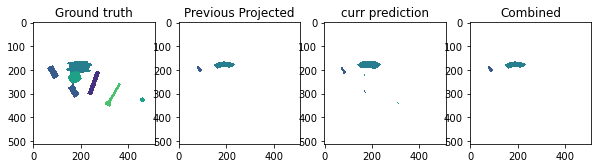

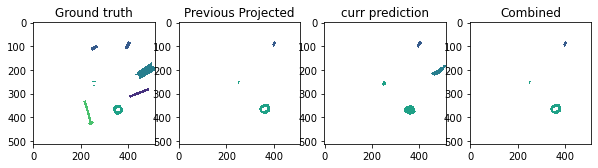

In [93]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for prev_image, proj_image, curr_image, pr_image in zip(batch["mask1"], projected_image, logits_image1, combined):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 4, 1)
    data = prev_image.numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)  # convert CHW -> HWC
    plt.title("Ground truth")
    #plt.axis("off")

    plt.subplot(1, 4, 2)
    data = proj_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7) # just squeeze classes dim, because we have only one class
    plt.title("Previous Projected")
    #plt.axis("off")

    plt.subplot(1, 4, 3)
    data = curr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("curr prediction")
    
    plt.subplot(1, 4, 4)
    data = pr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("Combined")
    #plt.axis("off")
    
  
    plt.show()
    

## Comparing Dampster Schafer vs  constructuve vs bayesian 

In [9]:
model = SequenceRoboCupModel("FPN", "timm-mobilenetv3_small_minimal_100", in_channels=3, out_classes=6, combine_method='sum',
                            K=valid_dataset.K, Kinv=valid_dataset.Kinv, fusion_method=None)
model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')

In [142]:
batch = next(iter(valid_dataloader))

logits_image0 = model(batch['image0'])
logits_image1 = model(batch['image1'])
logits_image0 = torch.nn.functional.relu(logits_image0) +  1
logits_image1 = torch.nn.functional.relu(logits_image1) +  1


bs, channel, height, width = batch['image0'].shape
epipolar_propagation = EpipolarPropagation(valid_dataset.K, valid_dataset.Kinv, height, width, fill_empty_with_ones=True)
projected_image = epipolar_propagation(logits_image0, 
                                         batch['depth0'], 
                                         batch['translation_old_to_new_camera_frame'],
                                         batch['rotation_old_to_new_camera_frame'])
print (projected_image.shape)


cuda
torch.Size([2, 6, 512, 512])


In [130]:
print (logits_image0.isnan().any(), logits_image1.isnan().any(), projected_image.isnan().any())


tensor(False) tensor(False) tensor(False, device='cuda:0')


In [131]:
print (logits_image0.min(), logits_image1.min(), projected_image.min())

tensor(1., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MinBackward1>)


### Bayesian

In [132]:
with open('robocup_mobilenet_cm.npy', 'rb') as f:
    cm = np.load(f)
print (cm.shape)
ef_fusion = EffectiveProbability(confusion_matrix=cm)


(6, 6)


In [133]:
combined = ef_fusion(projected_image, logits_image1)
combined.shape

torch.Size([524288, 6])

In [135]:
projected_image = projected_image.argmax(dim=1, keepdim=True)
logits_image1 = logits_image1.argmax(dim=1, keepdim=True)
combined = combined.argmax(dim=1, keepdim=True)
combined = combined.reshape(bs, 1, height, width)
combined.shape

torch.Size([2, 1, 512, 512])

In [126]:
import matplotlib.pyplot as plt

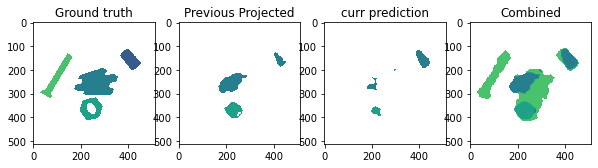

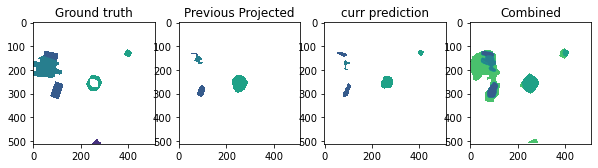

In [136]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for prev_image, proj_image, curr_image, pr_image in zip(batch["mask1"], projected_image, logits_image1, combined):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 4, 1)
    data = prev_image.numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)  # convert CHW -> HWC
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    data = proj_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7) # just squeeze classes dim, because we have only one class
    plt.title("Previous Projected")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    data = curr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("curr prediction")
    
    plt.subplot(1, 4, 4)
    data = pr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("Combined")
    plt.axis("off")
    
  
    plt.show()
    

### Dirchlet damspter 

In [140]:
with open('robocup_mobilenet_cm.npy', 'rb') as f:
    cm = np.load(f)
print (cm.shape)
ef_fusion = EffectiveProbability(confusion_matrix=cm, fusion_type='dampster')

combined = ef_fusion(projected_image, logits_image1)
combined.shape

projected_image = projected_image.argmax(dim=1, keepdim=True)
logits_image1 = logits_image1.argmax(dim=1, keepdim=True)
combined = combined.argmax(dim=1, keepdim=True)
combined = combined.reshape(bs, 1, height, width)
combined.shape

(6, 6)


torch.Size([2, 1, 512, 512])

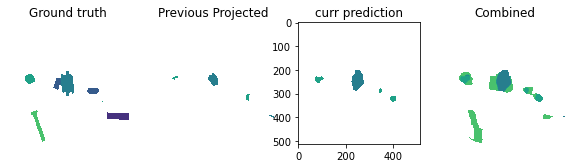

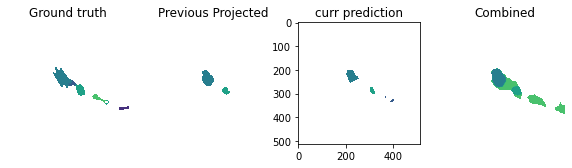

In [141]:
for prev_image, proj_image, curr_image, pr_image in zip(batch["mask1"], projected_image, logits_image1, combined):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 4, 1)
    data = prev_image.numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)  # convert CHW -> HWC
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    data = proj_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7) # just squeeze classes dim, because we have only one class
    plt.title("Previous Projected")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    data = curr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("curr prediction")
    
    plt.subplot(1, 4, 4)
    data = pr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("Combined")
    plt.axis("off")
    
  
    plt.show()

### Addition

In [144]:

combined = projected_image.to(device) + logits_image1.to(device) 
combined.shape

projected_image = projected_image.argmax(dim=1, keepdim=True)
logits_image1 = logits_image1.argmax(dim=1, keepdim=True)
combined = combined.argmax(dim=1, keepdim=True)
combined = combined.reshape(bs, 1, height, width)
combined.shape

torch.Size([2, 1, 512, 512])

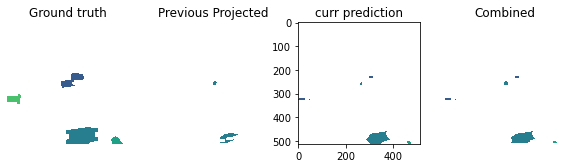

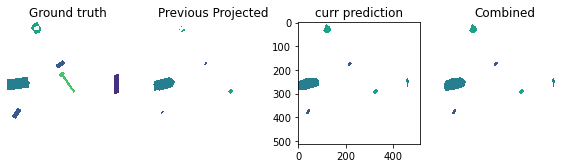

In [145]:
for prev_image, proj_image, curr_image, pr_image in zip(batch["mask1"], projected_image, logits_image1, combined):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 4, 1)
    data = prev_image.numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)  # convert CHW -> HWC
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    data = proj_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7) # just squeeze classes dim, because we have only one class
    plt.title("Previous Projected")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    data = curr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("curr prediction")
    
    plt.subplot(1, 4, 4)
    data = pr_image.cpu().detach().numpy().squeeze()
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("Combined")
    plt.axis("off")
    
  
    plt.show()